# Pomegranate Demo, featuring Chewbacca the YouTuber Cat

This presentation was derived from a mixture of source materials:
 - [Pomegranate Tutorials](https://github.com/jmschrei/pomegranate/tree/master/tutorials)
 - [Introduction to Hidden Markov Models with Python Networkx and Sklearn](http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017)

**Find this demo on github**:  [mooneyj3: cs571_hmm_demos](https://github.com/mooneyj3/cs571_hmm_demos)
***

### Course: CS 571, Machine Learning, Western Washington University (Brian Hutchinson)
**Assignment:  Advanced Lecture Topics, Hidden Markov Models**

**Author**: Jonny Mooneyham with Alex Emanuelson and Simon Haile
***

# Getting Started
Pomegranate is the main package we will use. Pomegranates flagship product is the Hidden Markov Model Package (HMM)

In [1]:
from pomegranate import *
import numpy as np
import pandas as pd # used to display data nicely

# Background
Chewbacca is a cat.  He has four activities that we observe: sleeping, eating, destroying furniture, and making YouTube videos.

The initial probability of any of these states is given below based on what we know about cats and Chewbacca.

In [2]:
states = ['sleep', # cats sleep for 60% of their lives
          'eat',   # cats are crepuscular, active during twilight
          'destroy_furniture',  # cats contribute to 10.2% of annual revenues in the furniture industry
          'make_videos'] # there are more than 2 million cat videos on YouTube
pi = [0.6, 0.05, 0.1, 0.25]

# create state space and initial state probabilities

state_space = pd.Series(pi, index=states, name='states')
# print(state_space)

(pd.DataFrame()
    .assign(Observation=states)
    .assign(Initial_Prob=pi)
)

,Observation,Initial_Prob
0,sleep,0.60
1,eat,0.05
2,destroy_furniture,0.10
3,make_videos,0.25


## Transition Probabilities
Next, we will define the transition probabilities.
These are the probabilities of staying in the same state or moving to a different state.
This is an (M x M) matrix where M is the number of states

In [3]:
q_df = pd.DataFrame(columns=states, index=states)

#      {state} -> [sleeping, eating, dest_furn, make_vids]
q_df.loc[states[0]] = [0.4, 0.2, 0.05, 0.35] # sleep 
q_df.loc[states[1]] = [0.8, 0.05, 0.1, 0.05] # eating
q_df.loc[states[2]] = [0.6, 0.05, 0.1, 0.25] # dest_furn
q_df.loc[states[3]] = [0.1, 0.4, 0.1, 0.4] #make_vids

print(q_df)

q = q_df.values
# print('\n', q, q.shape, '\n')

print("\nProbability Totals")
print(q_df.sum(axis=1))

                  sleep   eat destroy_furniture make_videos
sleep               0.4   0.2              0.05        0.35
eat                 0.8  0.05               0.1        0.05
destroy_furniture   0.6  0.05               0.1        0.25
make_videos         0.1   0.4               0.1         0.4

Probability Totals
sleep                1.0
eat                  1.0
destroy_furniture    1.0
make_videos          1.0
dtype: float64


# Chewbacca's Markov Chain
What we have now is a Markov Chain for Chewbacca's activities.
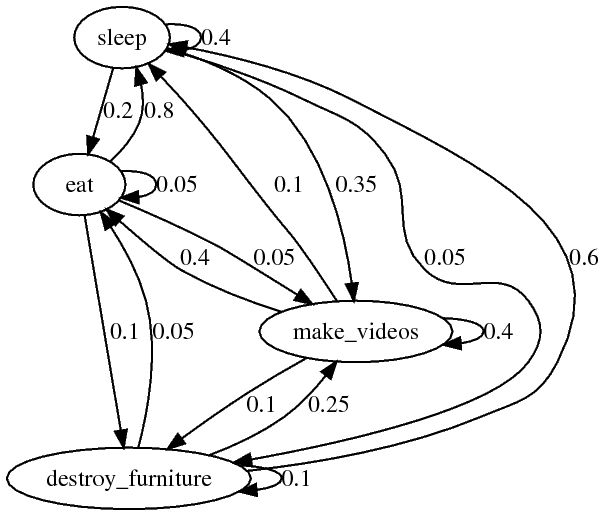

### Implementing Markov Chains in Pomegranate
Fortunately, the setup for this is fairly straightforward, but a little more arduous than my example above.

From the Pomegranate library, we will create a discrete distrubtion, and a conditional probability table.

Last, we will initialize a Markov Chain.

In [18]:
d1 = DiscreteDistribution({'sleep': 0.6, 
                           'eat': 0.05,
                           'destroy_furniture': 0.1, 
                           'make_videos': 0.25})

d2 = ConditionalProbabilityTable([['sleep', 'sleep', 0.4],
                                  ['sleep', 'eat', 0.2],
                                  ['sleep', 'destroy_furniture', 0.05],
                                  ['sleep', 'make_videos', 0.35],
                                  ['eat', 'sleep', 0.8],
                                  ['eat', 'eat', 0.05],
                                  ['eat', 'destroy_furniture', 0.1],
                                  ['eat', 'make_videos', 0.05], 
                                  ['destroy_furniture', 'sleep', 0.6],
                                  ['destroy_furniture', 'eat', 0.05],
                                  ['destroy_furniture', 'destroy_furniture', 0.1],
                                  ['destroy_furniture', 'make_videos', 0.25],
                                  ['destroy_furniture', 'sleep', 0.1],
                                  ['destroy_furniture', 'eat', 0.4],
                                  ['destroy_furniture', 'destroy_furniture', 0.1], 
                                  ['destroy_furniture', 'make_videos', 0.4]],
                                [d1])

clf = MarkovChain([d1, d2])

## Log Probabilities
**From the Docs**: Markov chains have log probability, fit, summarize, and from summaries methods implemented. They do not have classification capabilities by themselves, but when combined with a Naive Bayes classifier can be used to do discrimination between multiple models (see the Naive Bayes tutorial notebook).

In [5]:
log_prob = clf.log_probability( ["eat", "sleep", "eat", "eat", "eat", "destroy_furniture", "make_videos"] )
print(log_prob)
print(np.exp(log_prob))

-14.03865410927848
8.000000000000025e-07


In [6]:
log_prob = clf.log_probability( ["sleep"] )
print(log_prob)
print(np.exp(log_prob))

-0.5108256237659907
0.6


In [7]:
log_prob = clf.log_probability( ["sleep" , "sleep", "sleep"])
print(log_prob)
print(np.exp(log_prob))

-2.3434070875143007
0.09600000000000002


## Fitting data to a Markov Chain
We can fit the model to sequences which we pass in, and as expected, get better performance on sequences which we train on.  We can view the resulting probabilities of these specific sequences.

In [14]:
clf.fit([["eat", "sleep", "eat", "eat", "eat", "destroy_furniture", "make_videos"],
         ["sleep"],
         ["sleep" , "sleep", "sleep"]])

print(clf.log_probability(["eat", "sleep", "eat", "eat", "eat", "destroy_furniture", "make_videos"]))
print(clf.log_probability(["sleep"]))
print(clf.log_probability(["sleep" , "sleep", "sleep"]))

-6.3561076606958915
-0.40546510810816444
-1.2163953243244934


### After fitting (training) the model with new data
The Markov model has changed, we can now view the new distributions that the model has learned.

In [19]:
print(clf.distributions[0])

{
    "class" :"Distribution",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "sleep" :0.6,
            "eat" :0.05,
            "destroy_furniture" :0.1,
            "make_videos" :0.25
        }
    ],
    "frozen" :false
}


In [20]:
print(clf.distributions[1])

sleep	sleep	0.4
sleep	eat	0.2
sleep	destroy_furniture	0.05000000000000001
sleep	make_videos	0.3499999999999999
eat	sleep	0.8
eat	eat	0.05000000000000001
eat	destroy_furniture	0.10000000000000002
eat	make_videos	0.05000000000000001
destroy_furniture	sleep	0.10000000000000002
destroy_furniture	eat	0.4
destroy_furniture	destroy_furniture	0.10000000000000002
destroy_furniture	make_videos	0.4


# Hidden Markov Model with Pomegranate

Evidently, Chewbacca's mood is affected by his viewer base and number of views on YouTube. The problem is, we don't know what his mood is, we can only guess.

We have two distributions, if his viewers are **increasing**, then Chewbacca's mood is usually good, he sleeps more, eats regularly and destroys less furniture, and keeps a steady pace of videos.  If viewership is **decreasing**, then he eats and sleeps less because he is depressed, destroys more furniture to vent his frustration, and creates more videos to try and get more users.

Since Chewbacca is a cat, he can't tell us if his viewership is increasing or decreasing, so we use a Hidden Markov Model to try and guess his current mood based on viewership.

We set up this scenario up using **Pomegranate**.  This can be setup with some initial observations or experience, or it can be setup with a random distribution if uncertainty is high.

In [22]:
increasing = DiscreteDistribution({'sleep': 0.5, 
                                   'eat': 0.2,
                                   'dest': 0.05,                            
                                   'vids': 0.25})

decreasing = DiscreteDistribution({'sleep': 0.2, 
                                   'eat': 0.05,
                                   'dest': 0.4,                            
                                   'vids': 0.35})

s1 = State( increasing, name="increasing" )
s2 = State( decreasing, name="decreasing" )

hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)

Next, we setup the transitions. Chewbacca is generally in a good mood most of the time and has good viewership.

In [24]:
hmm.add_transition(hmm.start, s1, 0.8)
hmm.add_transition(hmm.start, s2, 0.2)
hmm.add_transition(s1, s1, 0.8)
hmm.add_transition(s1, s2, 0.2)
hmm.add_transition(s2, s1, 0.2)
hmm.add_transition(s2, s2, 0.8)
hmm.bake()

Now we can make some predictions about Chewy's mood based on some observations.

In [26]:
seq1 = ['sleep', 'eat', 'sleep', 'vids', 'sleep', 'dest', 'sleep', 'eat', 'vids', 'vids']
seq2 = ['dest', 'vids', 'dest', 'vids', 'dest', 'vids', 'sleep', 'sleep', 'sleep']

print("0:", hmm.states[0].name)
print("1:", hmm.states[1].name, end="\n\n")

predictions1 = hmm.predict( seq1 )
print("sequence: {}".format( "\t".join( seq1 )))
print("hmm pred: {}".format( "\t".join( map( str, predictions1)) ), end="\n\n")

predictions2 = hmm.predict( seq2 )
print("sequence: {}".format( "\t".join( seq2 )))
print("hmm pred: {}".format( "\t".join( map( str, predictions2)) ))

0: decreasing
1: increasing

sequence: sleep	eat	sleep	vids	sleep	dest	sleep	eat	vids	vids
hmm pred: 1	1	1	1	1	0	1	1	1	0

sequence: dest	vids	dest	vids	dest	vids	sleep	sleep	sleep
hmm pred: 0	0	0	0	0	0	1	1	1


Predictions are made based off of probabilities, we can look at these prediction probabilities using `predect_proba`.

In [242]:
probs1 = hmm.predict_proba( seq1 )

print("state 0:", hmm.states[0].name)
print("state 1:", hmm.states[1].name)
print()

print ("       ", hmm.states[0].name, "", hmm.states[1].name,"\t\tprediction")
for i in range(len(seq1)):
    print(seq1[i], probs1[i], "", predictions1[i],sep="\t")

state 0: decreasing
state 1: increasing

        decreasing  increasing 		prediction
sleep	[0.03775431 0.96224569]		1
eat	[0.05113983 0.94886017]		1
sleep	[0.12944284 0.87055716]		1
vids	[0.31235225 0.68764775]		1
sleep	[0.35368476 0.64631524]		1
dest	[0.63454255 0.36545745]		0
sleep	[0.31494002 0.68505998]		1
eat	[0.23641257 0.76358743]		1
vids	[0.43505411 0.56494589]		1
vids	[0.51560427 0.48439573]		0


In [27]:
probs2 = hmm.predict_proba( seq1 )

print("state 0:", hmm.states[0].name)
print("state 1:", hmm.states[1].name)
print()

print ("       ", hmm.states[0].name, "", hmm.states[1].name,"\t\tprediction")
for i in range(len(seq2)):
    print(seq2[i], probs2[i], "", predictions2[i],sep="\t")

state 0: decreasing
state 1: increasing

        decreasing  increasing 		prediction
dest	[0.03775431 0.96224569]		0
vids	[0.05113983 0.94886017]		0
dest	[0.12944284 0.87055716]		0
vids	[0.31235225 0.68764775]		0
dest	[0.35368476 0.64631524]		0
vids	[0.63454255 0.36545745]		0
sleep	[0.31494002 0.68505998]		1
sleep	[0.23641257 0.76358743]		1
sleep	[0.43505411 0.56494589]		1


These are the emission probability values calculated by the forward backward algorithm, and can also be retrieved by calling the `hmm.forward_backward( seq )`, which returns the emissions and the transition probability tables.

The emissions are the log probabilities, which we have already seen converted into normal probabilities above.

In [29]:
trans, ems = hmm.forward_backward(seq1)
print(trans)

[[1.77764161 0.72768163 0.         0.        ]
 [1.20553159 5.28914517 0.         0.        ]
 [0.03775431 0.96224569 0.         0.        ]
 [0.         0.         0.         0.        ]]


(from the docs)

This is the transition table, which has the soft count of the number of transitions across an edge in the model given a single sequence. It is a square matrix of size equal to the number of states (including start and end state), with number of transitions from (row_id) to (column_id). These counts are not normalized to the length of the input sequence, but can easily be done so by dividing by row sums, column sums, or entire table sums, depending on your application.

A possible reason not to normalize is to run several sequences through and add up their tables, because normalizing in the end and extracting some domain knowledge.

We've been using the forward backward algorithm and maximum a posteriori for decoding thus far, however maximum a posteriori decoding has the side effect that it is possible that it predicts impossible sequences in some edge cases. An alternative is **Viterbi** decoding, which at each step takes the most likely path, instead of sum of all paths, to produce hard assignments.

In [30]:
print("hmm state 0: {}".format( hmm.states[0].name ))
print("hmm state 1: {}".format( hmm.states[1].name ))
print()

hmm_predictions1 = hmm.predict( seq1, algorithm='viterbi' )[1:]
print("sequence1: {}".format( '\t'.join( seq1 ) ))
print("hmm pred1: {}".format( '\t'.join( map( str, hmm_predictions1 ) ) ))

print()
hmm_predictions2 = hmm.predict( seq2, algorithm='viterbi' )[1:]
print("sequence2: {}".format( '\t'.join( seq2 ) ))
print("hmm pred: {}".format( '\t'.join( map( str, hmm_predictions2 ) ) ))

hmm state 0: decreasing
hmm state 1: increasing

sequence1: sleep	eat	sleep	vids	sleep	dest	sleep	eat	vids	vids
hmm pred1: 1	1	1	1	1	1	1	1	1	1

sequence2: dest	vids	dest	vids	dest	vids	sleep	sleep	sleep
hmm pred: 0	0	0	0	0	0	1	1	1


# Training HMM's
There are two main algorithms for training hidden Markov models-- Baum Welch (structured version of Expectation Maximization), and Viterbi training. **Since we don't start off with labels on the data, these are both unsupervised training algorithms.** In order to assign labels, Baum Welch uses EM to assign soft labels (weights in this case) to each point belonging to each state, and then using weighted MLE estimates to update the distributions. Viterbi assigns hard labels to each observation using the Viterbi algorithm, and then updates the distributions based on these hard labels.

We use the exact variables as above and create `hmm2` this time.

In [38]:
increasing = DiscreteDistribution({'sleep': 0.5, 
                                   'eat': 0.2,
                                   'dest': 0.05,                            
                                   'vids': 0.25})

decreasing = DiscreteDistribution({'sleep': 0.2, 
                                   'eat': 0.05,
                                   'dest': 0.4,                            
                                   'vids': 0.35})

s1 = State( increasing, name="increasing" )
s2 = State( decreasing, name="decreasing" )

hmm2 = HiddenMarkovModel()
hmm2.add_states(s1, s2)

hmm2.add_transition(hmm2.start, s1, 0.8)
hmm2.add_transition(hmm2.start, s2, 0.2)
hmm2.add_transition(s1, s1, 0.8)
hmm2.add_transition(s1, s2, 0.2)
hmm2.add_transition(s2, s1, 0.2)
hmm2.add_transition(s2, s2, 0.8)
hmm2.bake()

Awesome, now lets feed some data in and apply the `baum-welch` algorithm.  The result prints the training improvement.  Inertia is used to prevent updates from overfitting.

In [41]:
hmm2.fit( [seq1, seq2,
           ['sleep'], 
          ['eat', 'dest', 'vids'],
          ['sleep', 'sleep', 'sleep', 'sleep'],
          ['dest', 'sleep', 'dest', 'sleep', 'dest', 'eat']
         ],
         algorithm='baum-welch',
         max_iterations=5,
         distribution_inertia=0.3,
         edge_inertia=0.1)

59.605069030425064

As more samples are added, the training improvement will be affected.

In [43]:
hmm2.fit( [['eat', 'dest', 'sleep'], 
          ['dest', 'eat', 'sleep'],
          ['eat', 'eat', 'eat', 'eat'],
          ['dest', 'eat', 'sleep', 'sleep', 'sleep', 'eat']
         ],
         algorithm='baum-welch',
         distribution_inertia=0.3,
         edge_inertia=0.1)

12.460881043687358

# Predicting On the Trained Model
Now that we have a model, we can make predictions with some new observed sequences.

In [44]:
seq3 = ['dest', 'eat', 'dest', 'eat', 'vids', 'vids', 'sleep']
seq4 = ['dest', 'vids', 'dest', 'vids', 'dest', 'vids', 'dest', 'sleep', 'sleep', 'sleep']

predictions_hmm2 = hmm.predict( seq3 )
print("sequence: {}".format( "\t".join( seq3 )))
print("hmm pred: {}".format( "\t".join( map( str, predictions_hmm2)) ), end="\n\n")

predictions_hmm2 = hmm.predict( seq4 )
print("sequence: {}".format( "\t".join( seq4 )))
print("hmm pred: {}".format( "\t".join( map( str, predictions_hmm2)) ), end="\n\n")

sequence: dest	eat	dest	eat	vids	vids	sleep
hmm pred: 0	1	0	1	1	1	1

sequence: dest	vids	dest	vids	dest	vids	dest	sleep	sleep	sleep
hmm pred: 0	0	0	0	0	0	0	1	1	1



## What has our model learned?
What do the transitions look like betwene the two models (hmm and hmm2)?

How have they changed with training?

In [46]:
trans1, _ = hmm.forward_backward(seq3)
print(trans1)

trans2, _ = hmm2.forward_backward(seq3)
print(trans2)

[[2.14863232 0.88474332 0.         0.        ]
 [0.63318129 2.33344306 0.         0.        ]
 [0.57970635 0.42029365 0.         0.        ]
 [0.         0.         0.         0.        ]]
[[3.03065909e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.98104709e-20 1.96934091e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.84374003e-45 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
